In [1]:
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import golden
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
import uuid
import os
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import pytz
import random
from collections import OrderedDict 
from matplotlib import animation
import collections

In [2]:
today = datetime.datetime.today()
# Select your local timezone to get the right date when running the notebook
localtimezone = pytz.timezone("US/Pacific")
today = today.astimezone(localtimezone)
print(f"{today.year}-{today.month:02d}-{today.day:02d}")

2020-06-07


In [3]:
filename = f"https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{today.year}-{today.month:02d}-{today.day:02d}.xlsx"

In [4]:
df = pd.read_excel(filename)

In [5]:
df = df[::-1]
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
21964,2020-03-21,21,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
21963,2020-03-22,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
21962,2020-03-23,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
21961,2020-03-24,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0,Africa
21960,2020-03-25,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa


In [6]:
datecol = df.columns[0]
cases = df.columns[4]
country = df.columns[7]
datecol, cases, country

('dateRep', 'cases', 'geoId')

In [7]:
def logarithmic_curve(x, a, b, c, d):
    """
    Logistic function with parameters a, b, c, d
    a is the curve's maximum value
    b is an offset value
    c is the logistic growth rate or steepness of the curve
    d is the x value of the sigmoid's midpoint
    """
    return a / (1 + np.exp(-c * (x - d))) + b

In [8]:
def exp_curve(x, a, b):
    return a*np.exp(b*x)

In [9]:
def sigmoid_derivative(x, a, b, c, d, e, f):
    return logarithmic_curve(x, a, b, c)*(1-logarithmic_curve(x, d, e, f))

In [10]:
def covid_graphs(selectedcountry, threshold=10, image_width=6, show_deaths=False, save_figure=False):
    nrows = 2
    ncols = 2
    markersize = 10
    rolling_windows_days = 15
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(image_width*ncols, image_width*nrows))
    fig.tight_layout(pad=3.0)
    confirmed = df[(df['cases'] >= 1) & (df[country]==selectedcountry)]['cases']
    confirmed_daily = confirmed.values
    confirmed_cumsum = confirmed.cumsum().values
    deaths = df[(df['cases'] >= 1) & (df[country]==selectedcountry)]['deaths']
    population = df[df[country] == selectedcountry]['popData2018'].values[-1]
    
    if confirmed_daily.sum() < 10:
        # return empty plot if there are less than 10 total cases for the selected country
        return 0
    x_infections = 0.6
    y_infections = 0.03
    if confirmed_daily[-1]/max(confirmed_daily) < 0.5:
        y_infections = 0.93
    if show_deaths:
        axs[0, 0].plot(np.arange(0, len(deaths)), deaths.values, color='#c9c9c9', label='daily deaths')
        axs[0, 0].text(0.65, max(deaths)/max(confirmed_daily), f"Deaths: {deaths.sum()}", transform=axs[0, 0].transAxes)
        axs[0, 1].bar(np.arange(0, len(deaths)), deaths.cumsum().values, color='#c9c9c9', label='cumulative deaths')
        axs[0, 1].text(0.65, 0.9, f"Deaths: {deaths.sum()}", transform=axs[0, 1].transAxes)
        if confirmed_daily[-1]/max(confirmed_daily) > 0.7:
            x_infections = 0.05
            y_infections = 0.5
        else:
            y_infections = 0.93
            
            
    # 1st graph: new cases and accummulated cases in linear y-scale
    axs[0, 0].plot(np.arange(0, len(confirmed_daily)), confirmed_daily, color='#fc5e03', label='daily')
    axs[0, 0].plot(np.arange(0, len(confirmed.rolling(window=7).mean())), confirmed.rolling(window=rolling_windows_days).mean(),
                   color='b', alpha=0.8, label=f"{rolling_windows_days}-day average")
    #     axs[0, 0].plot(np.arange(0, len(confirmed_cumsum)), confirmed_cumsum, color='b', label='cumulative')
    axs[0, 0].plot(np.argmax(confirmed_daily), max(confirmed_daily), ".",  markersize=markersize, color='r', label=f'Max cases in one day ({max(confirmed_daily):,})')
#     axs[0, 0].text(np.argmax(confirmed_daily), max(confirmed_daily), str(max(confirmed_daily)))
    axs[0, 0].set_yscale('linear')
    axs[0, 0].set_xlabel('Days since first infection')
    
#     axs[0, 0].text(x_infections, y_infections, f"Infections: {confirmed_daily.sum():,}\n{confirmed_daily.sum()/df[df[country]==selectedcountry]['popData2018'].values[0]*1e6:,.0f} inf./1M people", transform=axs[0, 0].transAxes)
    axs[0, 0].legend(title=f"Infections: {confirmed_daily.sum():,} ({confirmed_daily.sum()/df[df[country]==selectedcountry]['popData2018'].values[0]*1e6:,.0f}/1M)",
                     loc='best')
#     leg = axs[0, 0].legend(loc='best')
    axs[0, 0].set_title('Infections')
    axs[0, 0].grid(which='major', axis='y', alpha=0.7, linewidth=0.7)
    
    # 2nd graph: new cases and accummulated cases in logarithmic y-scale
    axs[0, 1].set_yscale('log')
    axs[0, 1].plot(np.arange(0, len(confirmed_daily)), confirmed_daily, color='#fc5e03', label='daily')
    axs[0, 1].plot(np.arange(0, len(confirmed_cumsum)), confirmed_cumsum, color='b', label='cumulative')
#     axs[0, 1].text(0.60, 0.03, f"Infections: {confirmed_daily.sum():,}\n{confirmed_daily.sum()/df[df[country]==selectedcountry]['popData2018'].values[0]*1e6:,.0f} inf./1M people", transform=axs[0, 1].transAxes)
    axs[0, 1].plot(np.argmax(confirmed_daily), max(confirmed_daily), ".",  markersize=markersize, color='r', label='Max cases in one day')
    
#     axs[0, 1].plot(np.arange(1, len(confirmed_daily)), np.clip(2**(np.arange(0.0, len(confirmed_daily)-1)), 0, max(confirmed_cumsum)), color='#9a9a9a', ls='--')
#     axs[0, 1].plot(np.arange(1, len(confirmed_daily)), (np.arange(1.0, len(confirmed_daily)))**2/(np.arange(0.0, len(confirmed_daily)-1)), color='#9a9a9a', ls='--')
    
    axs[0, 1].set_xlabel('Days since first infection')
    axs[0, 1].legend(title=f"Infections: {confirmed_daily.sum():,} ({confirmed_daily.sum()/df[df[country]==selectedcountry]['popData2018'].values[0]*1e6:,.0f}/1M)",
                     loc='best')
    axs[0, 1].set_title('Infections (logarithmic scale)')
#     axs[0, 1].grid('on', alpha=0.7, linewidth=0.7)
    axs[0, 1].grid(which='major', axis='y', alpha=0.7, linewidth=0.7)


    # 3rd graph: growth factor evolution
    growth_rate = confirmed_daily/df[(df[country] == selectedcountry) & (df['cases'] >= 1)]['cases'].shift().values
    growth_rate_indices = df[(df[country] == selectedcountry) & (df['cases'] >= 1)].index
    growth_ratedf = df[(df[country] == selectedcountry) & (df['cases'] >= 1)]['cases']/df[(df[country] == selectedcountry) & (df['cases'] >= 1)]['cases'].shift()
    rolling_mean = growth_ratedf.rolling(window=rolling_windows_days).mean()
    lr = LinearRegression()
    days_gr = [(df.loc[idx, datecol] - df[(df[country] == selectedcountry) & (df['cases'] >= 1)]['dateRep'].min()).days for idx in df[(df[country] == selectedcountry) & (df['cases'] >= 1)].index]
    days_gr = np.array(days_gr)
    lr.fit(days_gr[1:].reshape(-1,1), growth_rate[1:].reshape(-1,1))
    growth_trend = lr.predict(days_gr[1:].reshape(-1,1))
    
#     axs[1, 0].bar(np.arange(0, len(growth_rate)), growth_rate, color='#bababa', label='daily rate')
    axs[1, 0].plot(np.arange(0, len(rolling_mean.values)), rolling_mean.values, color='#fc5e03', linewidth=2, label=f'{rolling_windows_days}-day average')
    axs[1, 0].plot(np.arange(0, len(days_gr[1:])), growth_trend, color='#0000ff', label='trend')
    axs[1, 0].hlines(1.0, 0, len(days_gr[1:]), color='#000000', ls="--", lw=1, label='No growth')
#     axs[1, 0].text(len(growth_rate)*.85, (1/(np.nanmean(growth_rate)+2*np.nanstd(growth_rate)))*0.85, "No growth", size=9)
#     if (9/(np.nanmean(growth_rate)+2*np.nanstd(growth_rate))) < 0.85:
#         y_text = 0.85 - (9/(np.nanmean(growth_rate)+2*np.nanstd(growth_rate)))
#     else:
#         y_text = 0.85

#     axs[1, 0].text(-0.5, y_text, "No growth", size=9)
    axs[1, 0].text(.67, 0.82, f"Current = {growth_rate[-1]:.2f}", size=10, transform=axs[1, 0].transAxes)
    axs[1, 0].text(.67, 0.79, f"{rolling_windows_days}-day avg= {rolling_mean.values[-1]:.2f}", size=10, transform=axs[1, 0].transAxes)
    
    if round(rolling_mean.values[-1], 2) > 1/np.log10(2):
        axs[1, 0].text(.62, 0.76, f"New cases double every day", size=10, transform=axs[1, 0].transAxes) 
    elif round(rolling_mean.values[-1], 2) > 1:
        axs[1, 0].text(.57, 0.76, f"New cases double every {np.log10(2)/np.log10(rolling_mean.values[-1]):.0f} day{'s' if np.log10(2)/np.log10(rolling_mean.values[-1]) > 1 else ''}", size=10, transform=axs[1, 0].transAxes)
    
    axs[1, 0].set_xticks(np.arange(0, len(df[(df[country] == selectedcountry) & (df['cases'] >= 1)][cases]), 10))
    axs[1, 0].set_xlabel('Days since first infection')
    
#     axs[1, 0].set_ylim(bottom=0, top=np.nanmean(growth_rate)+2*np.nanstd(growth_rate))
    axs[1, 0].legend(loc='upper right')
    axs[1, 0].set_title('Growth factor')
    axs[1, 0].grid(which='major', axis='y', alpha=0.7, linewidth=0.7)
    
    # 4th graph: disease evolution prediction based on fit to logistic curve
    if len(confirmed) > 10:
        passed_inflection_point = False
                       
        # plot the actual cases reported in the database as blue dots
        axs[1, 1].plot(np.arange(0, len(confirmed)), confirmed_cumsum, ".", markersize=8, label="Reported cases")
                       
        # Create the x values for the fit function: number of days since the first infection
        # The y-values are the cumulative number of cases: confirmed.cumsum()
        x = np.arange(0, len(confirmed))
        # Set the initial parameters for the fit function
        # a = current maximum value
        # b = 1
        # c = 0.1
        # d = half the number of days with new infections for the selected country
        p0 = [confirmed.values.sum(), 1, 0.5, len(confirmed_daily)//2]
        myfunction = logarithmic_curve
        try:
            # actual fit to the logistic function
            logistic_params, covariance = curve_fit(myfunction, x, confirmed.cumsum().values, p0=p0)
            a, b, c, d = logistic_params
        except Exception as e1:
            print(e1)
            try:
                myfunction = exp_curve
                p0 = [1.0, 1.0]
                d = 0
                logistic_params, covariance = curve_fit(myfunction, x, confirmed.cumsum().values, p0=p0)
                a, b = logistic_params
            except Exception as e2:
                print(e2)
                return 0
        else:
        
            # Detect if the inflection point has been reached
            if d > 0 and d < len(confirmed):
                passed_inflection_point = True
            else:
                days_to_inflection = int(d)-len(confirmed)+1
                plural = f"{'s' if days_to_inflection > 1 else ''}"

            # Calculate how good is the fit
            confirmed_pred = myfunction(np.arange(0, len(confirmed)), *logistic_params)
            r2 = r2_score(confirmed.cumsum().values, confirmed_pred)

            # Plot R2 rendering LaTeX on the plot
            axs[1, 1].text(0.2, 0.3, f"$R^2$={r2:.4f}", transform=axs[1, 1].transAxes)

            # calculate when the max number of cases increases so little new cases are not increasing
            # this provides a slightly more accurate value than simply doubling the days of the inflection point
            # uncomment the following lines if you want to see the difference
            """
            days_pred = np.arange(len(confirmed)-(len(confirmed)%15), 360, 15)
            ypred = logarithmic_curve(days_pred, *logistic_params)

            diff_ypred = [ypred[i + 1] - ypred[i] for i in range(len(ypred)-1)]
            days_diff = days_pred[np.argmax(diff_ypred < np.max(diff_ypred)*0.000001)] - len(confirmed)

            x = np.arange(0, days_pred[np.argmax(diff_ypred < np.max(diff_ypred)*0.000001)])
            y = logarithmic_curve(x, *logistic_params)
            """
            # Calculate the whole curve using the double of days than the inflection point
            # Comment the next 3 lines if you are testing the calculation above
            x = np.arange(0, np.ceil(d*2))
            y = myfunction(x, *logistic_params)
            if myfunction == logarithmic_curve:
                y_inflection_point = myfunction(int(d), *logistic_params)
                days_diff = int(d) - len(confirmed)
                days_to_asymptote = int(d*2) - len(confirmed)

            if not len(y) > 0:
                y = [0]
            # plot a vertical black dotted line indicating the end of the actual data
            axs[1, 1].vlines(len(confirmed_daily), 0, max(max(y), confirmed_daily.sum()), color='k', ls=':', label="Today")

            # generate the inflection point label
            inflection_point_label = f"Inflection point{' in ' if not passed_inflection_point else ' '}{abs(days_diff+1 )} days{' ago' if passed_inflection_point else ''}"
            # plot a vertical red dotted line indicating the location of the inflection point as a reference
            axs[1, 1].vlines(int(d), 0.0, max(max(y), confirmed_daily.sum()), color='r', ls=':', label=inflection_point_label)

            # annotate the inflection point as a reference
            axs[1, 1].text(int(d)+1, y_inflection_point, f"{int(d)} days")
            # plot the fitted curve in orange
            axs[1, 1].plot(x, y, color='#fc5e03', label="Fitted logistic function")

            # plot the predicted maximum number of cases and the number of days until then
            text_x = len(confirmed)+2
            text_y = 0.05*max(max(y), confirmed_daily.sum())
            axs[1, 1].text(text_x, text_y, f"Day {len(confirmed)}") 
            if confirmed.cumsum().values[-1] < y[-1]:
                text_x = 0.4
                text_y = 0.01
                axs[1, 1].text(text_x, text_y, f"Cases in {abs(days_to_asymptote)} days from today: {int(y[-1]):,}", transform=axs[1, 1].transAxes)

            axs[1, 1].fill_between(x[len(confirmed):], confirmed.cumsum().values[-1], y[len(confirmed):],
                             facecolor="none", hatch="/", edgecolor=f"{'b' if passed_inflection_point else 'r'}", linewidth=0.0,
                             label=f"Predicted increase")
    
    axs[1, 1].set_xlabel('Days since first infection')
    axs[1, 1].legend(loc='upper left')
    axs[1, 1].set_title('Evolution (prediction)')
    axs[1, 1].grid(which='major', axis='y', alpha=0.7, linewidth=0.7)
    
    country_name = df[df[country] == selectedcountry]['countriesAndTerritories'].values[0]
    date_str = today.strftime("%B %d, %Y")
    plt.suptitle(f"COVID-19 evolution in {country_name} (pop. {population:,.0f})\n{date_str}", y=1.025, size=15)
  
    if save_figure:
        filename = f"{selectedcountry}_{today.year}-{today.month:02d}-{today.day:02d}_{uuid.uuid4().hex}.png"
        destination_folder = os.path.expanduser(r"~\Documents\COVID-19")
        if not os.path.isdir(destination_folder):
            try:
                os.mkdir(destination_folder)
            except Exception as e:
                print(e)
        plt.savefig(os.path.join(destination_folder, filename),
                    dpi=300, bbox_inches='tight')
        print(f"file saved as: {os.path.join(destination_folder, filename)}")


In [11]:
# countries = df[['countriesAndTerritories', country, 'cases']].groupby(['countriesAndTerritories', country], as_index=False)['cases'].sum().values
countries = df.loc[df[df['cases'] >= 1].index,['countriesAndTerritories', 'geoId', 'cases']].groupby(['countriesAndTerritories', country], as_index=False)['cases'].sum().values

countries = countries[countries[:,2].argsort()[::-1]]

countries = [(f"{a} ({c:,})", b) for a, b, c in countries]

%matplotlib inline
style = {'description_width': 'initial'}
output = widgets.interact(covid_graphs,
                          selectedcountry=widgets.Dropdown(options=countries,
                                                           value=countries[0][1],
                                                           description='Country (total):',
                                                           style=style),
                          threshold=widgets.IntSlider(10, 5, 500, 5), 
                          image_width=widgets.IntSlider(6, 3, 10, 1),
                          show_deaths=widgets.Checkbox(False, disabled=False),
                          save_figure=widgets.Checkbox(False, disabled=False))

interactive(children=(Dropdown(description='Country (total):', options=(('United_States_of_America (1,920,061)…

C:\ProgramData\Anaconda3\envs\ds36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


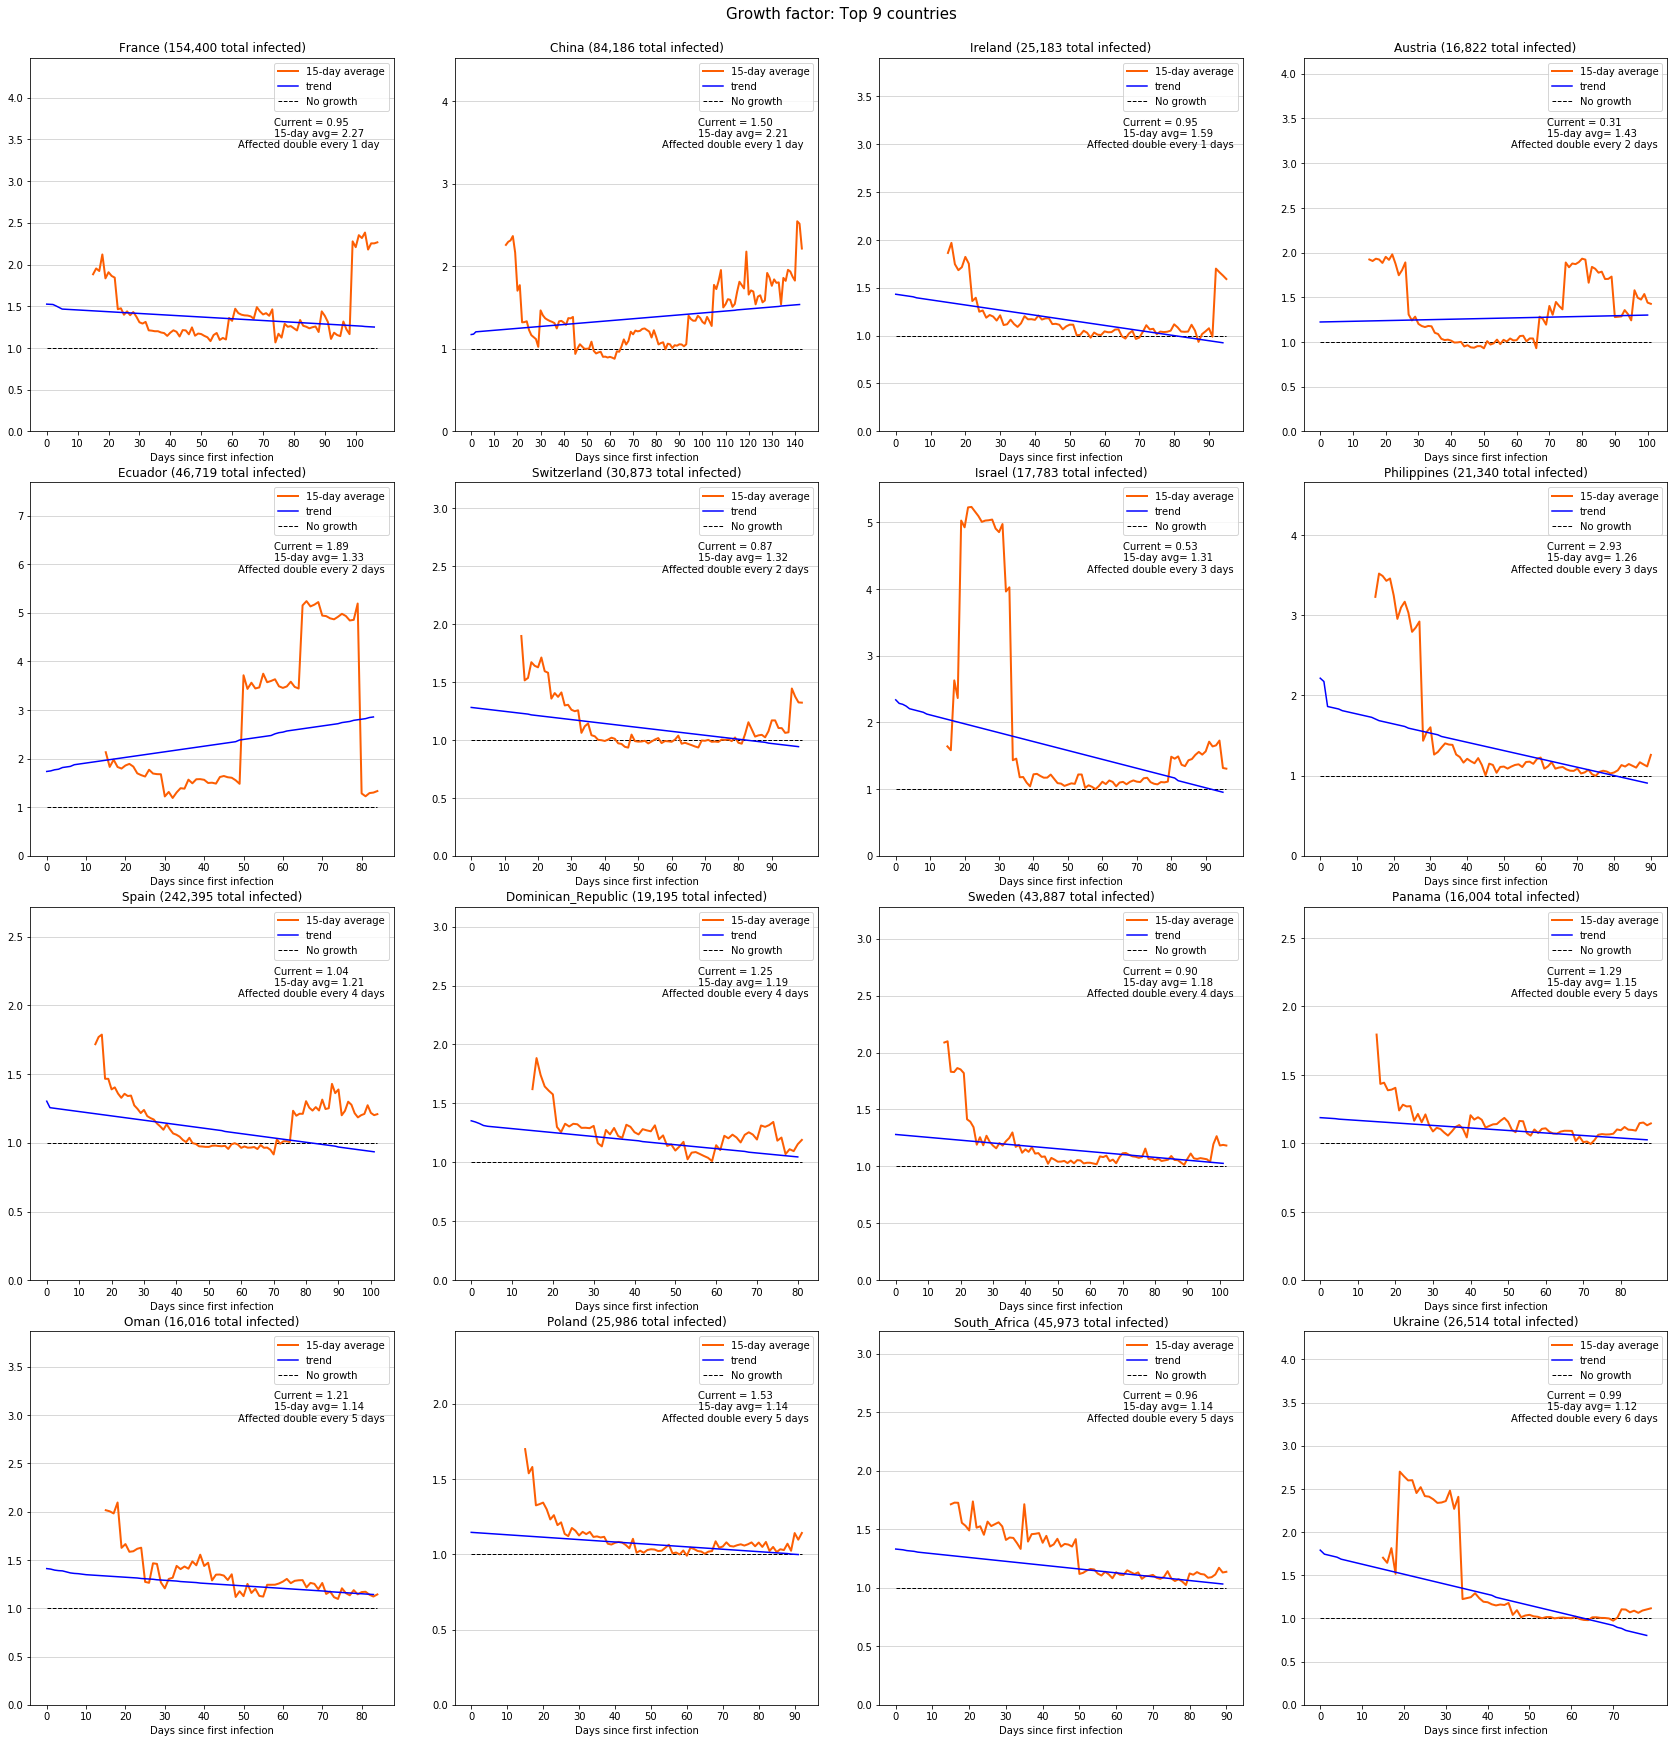

In [20]:
# Only display countries with at least 15,000 cases:
min_number_cases = 15000
growth_rates = []
rolling_windows_days = 15
for selectedcountry in df[country].unique():
    confirmed = df[(df['cases'] >= 1) & (df[country]==selectedcountry)]['cases']
    if len(confirmed) > 1:
        confirmed_daily = confirmed.values
        confirmed_cumsum = confirmed.cumsum().values
        growth_rate = confirmed_daily/df[(df[country] == selectedcountry) & (df['cases'] >= 1)]['cases'].shift().values
        growth_ratedf = df[(df[country] == selectedcountry) & (df['cases'] >= 1)]['cases']/df[(df[country] == selectedcountry) & (df['cases'] >= 1)]['cases'].shift()
        rolling_mean = growth_ratedf.rolling(window=rolling_windows_days).mean()
        if confirmed_cumsum[-1] > min_number_cases and len(growth_rate > 3) and len(rolling_mean.values) > 1 and rolling_mean.values[-1] > 1.0:
            growth_rates.append((selectedcountry, growth_rate[-1], rolling_mean.values[-1]))

growth_rates.sort(key = lambda x: x[2], reverse=True)

relevant_countries = np.array(growth_rates)[:,0].tolist()[:16]
nrows = ncols = int(np.ceil(len(relevant_countries)**0.5))


image_width = 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(image_width*ncols, image_width*nrows))
fig.tight_layout(pad=3.0)

df.fillna(0, inplace=True)
for i, selectedcountry in enumerate(relevant_countries):
    from scipy import stats
    countrydf = df[(df['cases'] >= 1) & (df[country]==selectedcountry)]
    confirmed = countrydf['cases']
    
    confirmed_daily = confirmed.values
    confirmed_cumsum = confirmed.cumsum().values
    deaths = countrydf['deaths']
    growth_rate = confirmed_daily/confirmed.shift().values

    growth_ratedf = confirmed/confirmed.shift()
    rolling_mean = growth_ratedf.rolling(window=rolling_windows_days).mean()
    
    lr = LinearRegression()
    days_gr = [(df.loc[idx, datecol] - countrydf['dateRep'].min()).days for idx in countrydf.index]
    days_gr = np.array(days_gr)
    lr.fit(days_gr[1:].reshape(-1,1), np.clip(growth_rate[1:], 0, np.mean(growth_rate[1:])*2*np.std(growth_rate[1:])).reshape(-1,1))
    growth_trend = lr.predict(days_gr[1:].reshape(-1,1))
    
    axs[i//nrows, (i%nrows)%ncols].plot(np.arange(0, len(rolling_mean.values)), rolling_mean.values, color='#fc5e03', linewidth=2, label=f'{rolling_windows_days}-day average')
    axs[i//nrows, (i%nrows)%ncols].plot(np.arange(0, len(days_gr[1:])), growth_trend, color='#0000ff', label='trend')
    axs[i//nrows, (i%nrows)%ncols].hlines(1.0, 0, len(days_gr[1:]), color='#000000', ls="--", lw=1, label='No growth')

#     if (9/(np.nanmean(growth_rate)+2*np.nanstd(growth_rate))) < 0.85:
#         y_text = 0.85 - (9/(np.nanmean(growth_rate)+2*np.nanstd(growth_rate)))
#     else:
#         y_text = 0.85

#     axs[i//nrows, (i%nrows)%ncols].text(-0.5, y_text, "No growth", size=9)
    axs[i//nrows, (i%nrows)%ncols].text(.67, 0.82, f"Current = {growth_rate[-1]:.2f}", size=10, transform=axs[i//nrows, (i%nrows)%ncols].transAxes)
    axs[i//nrows, (i%nrows)%ncols].text(.67, 0.79, f"{rolling_windows_days}-day avg= {rolling_mean.values[-1]:.2f}", size=10, transform=axs[i//nrows, (i%nrows)%ncols].transAxes)
    
    if round(rolling_mean.values[-1], 2) > 1/np.log10(2):
        axs[i//nrows, (i%nrows)%ncols].text(.62, 0.76, f"Affected double every day", size=10, transform=axs[i//nrows, (i%nrows)%ncols].transAxes) 
    elif round(rolling_mean.values[-1], 2) > 1:
        axs[i//nrows, (i%nrows)%ncols].text(.57, 0.76, f"Affected double every {np.log10(2)/np.log10(rolling_mean.values[-1]):.0f} day{'s' if np.log10(2)/np.log10(rolling_mean.values[-1]) > 1 else ''}", size=10, transform=axs[i//nrows, (i%nrows)%ncols].transAxes)
    
    axs[i//nrows, (i%nrows)%ncols].set_xticks(np.arange(0, len(confirmed), 10))
    axs[i//nrows, (i%nrows)%ncols].set_xlabel('Days since first infection')
    
    axs[i//nrows, (i%nrows)%ncols].set_ylim(bottom=0, top=min(np.nanmean(growth_rate)*3, np.nanmean(growth_rate)+2*np.nanstd(growth_rate)))
    axs[i//nrows, (i%nrows)%ncols].legend(loc='upper right')
    kountry = df[df[country]==selectedcountry]['countriesAndTerritories'].unique()[-1]
    axs[i//nrows, (i%nrows)%ncols].set_title(f'{kountry} ({confirmed_cumsum[-1]:,.0f} total infected)')
    axs[i//nrows, (i%nrows)%ncols].grid(which='major', axis='y', alpha=0.7, linewidth=0.7)
    
for i in range(len(relevant_countries), nrows**2):
    fig.delaxes(axs[i//nrows, (i%nrows)%ncols])
                                            
                                            
plt.suptitle("Growth factor: Top 16 countries", y=1.01, size=15)                          
plt.show()
# Uncomment the following lines to save the image on your hard disk                                            
#filename = f"Growth_rates_{today.year}-{today.month:02d}-{today.day:02d}_{uuid.uuid4().hex}.png"
# destination_folder = os.path.expanduser(r"~\Documents\COVID-19")
# plt.savefig(os.path.join(destination_folder, filename), dpi=300, bbox_inches='tight')
# print(f"file saved as: {os.path.join(destination_folder, filename)}")